<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/MomentNetwork_demo/moment_network_100D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Make network estimate 2 parameter mean, variance and covariance as a function of numer of training data

# Load modules

In [1]:
!pip install emcee getdist
!pip install chainconsumer
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super 

     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 747kB 6.4MB/s 
  Created wheel for getdist: filename=GetDist-1.1.2-cp36-none-any.whl size=197663 sha256=8268885fb6a01d55d126c56d872d7976f3bf9a5acd20c494d3c30a803ddfb77f
  Stored in directory: /root/.cache/pip/wheels/3f/b5/8a/e3d4221e66472ed329545d7026cec59dfd379256ca42692877
Successfully built getdist
     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for chainconsumer: filename=ChainConsumer-0.32.0-cp36-none-any.whl size=42349 sha256=7c5b2d93d71c81d0b7b823f6a8ddf1da5cb9e01a96920fc5917cf74e70433a65
  Stored in directory: /root/.cache/pip/wheels/66/dc/28/ad514ae6bc9dd12c4080b75d76b302145605bb008c24476d85
Successfully built chainconsumer
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgy

In [2]:
!pip install 'git+https://github.com/NiallJeffrey/MomentNetworks.git'

  Cloning https://github.com/NiallJeffrey/MomentNetworks.git to /tmp/pip-req-build-7b0o71en
  Running command git clone -q https://github.com/NiallJeffrey/MomentNetworks.git /tmp/pip-req-build-7b0o71en
  Created wheel for momentnetworks: filename=momentnetworks-0.1-cp36-none-any.whl size=3517 sha256=3277e21fa77fe086f1434d36d28b5cb2f33c1ea33e34833d2194dea770547db4
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xfj0gaw/wheels/d5/90/42/833efe39b17eb037678ff241c8946e912987034b18c69e2813
Successfully built momentnetworks


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gc
import numpy as np
from momentnetworks import demo
import os, sys
import random
import emcee as mc
import getdist
from google.colab import files
from getdist import plots, MCSamples
import time
from chainconsumer import ChainConsumer

# Generate data

In [4]:
n_training = 80000
size=100

training_z, cov_signal, cov_signal_inv = demo.generate__signal(size, n_training)

/usr/local/lib/python3.6/dist-packages/momentnetworks/demo.py:76: RuntimeWarning: covariance is not positive-semidefinite.
  training_z = np.random.multivariate_normal(np.zeros(size),cov_signal,n_training)


In [5]:
cov_noise = np.identity(size)*4
cov_noise_inv = np.linalg.pinv(cov_noise)
training_data = training_z +  np.random.multivariate_normal(np.zeros(size),cov_noise,n_training)

training_z_obs = [0.014, 0.996, 0.865, -0.25, 0.591, -0.104, 1.376, 1.022, 0.901, 0.835, 0.602, -0.157, -0.398, 0.483, -0.498, -1.437, -0.194, -0.535, -1.487, -1.103, -0.804, -0.741, -2.356, -0.235, -0.377, -0.081, 0.407, 0.777, 1.065, 0.959, 0.604, 2.419, 1.796, 1.261, 0.352, 1.648, 1.197, 0.782, 1.352, 1.61, 1.166, 0.497, 0.407, 0.737, 0.375, -0.484, 1.102, 1.316, 0.607, 1.3, 1.173, -0.642, -0.421, 0.53, 0.918, 1.763, 0.936, 1.27, 1.421, 1.757, 0.264, -0.061, 0.161, -0.033, 0.783, 0.533, 0.98, 0.509, 0.363, -1.247, -0.803, 0.065, -0.025, -0.073, 0.241, -0.744, 0.153, -0.711, 0.645, -0.539, -0.37, -0.748, -0.558, -0.188, 0.068, -0.524, -0.882, -0.367, -0.424, -0.93, -1.455, -2.157, -2.84, -0.588, -2.276, 0.246, -0.958, -0.591, 0.14, 0.156]
training_data_obs = [-1.607, 3.04, -0.357, -1.089, 2.622, -1.42, 4.596, -0.384, 4.087, -1.155, 1.745, -0.054, -3.418, -1.398, 1.598, 2.363, -1.018, -0.183, -1.317, -0.787, -0.046, 0.762, -4.387, 2.829, 2.406, 0.452, -0.132, -3.245, -1.389, 0.862, -0.146, -1.218, -0.634, 0.22, 2.792, 5.549, 5.298, 1.558, -2.26, -0.169, 2.297, 0.402, 0.644, 1.033, 3.076, -1.034, -3.227, 3.307, 0.463, 2.226, 2.847, 1.456, 1.012, 2.702, 2.812, 6.682, -1.643, 0.749, 2.727, 3.234, 0.139, 0.077, -0.899, 1.283, 3.093, -0.528, 2.225, 2.873, 1.314, -0.133, -1.184, 1.331, 1.148, 3.614, -0.678, 0.146, 1.136, -3.905, 0.178, 2.195, -0.533, -2.579, -1.13, -5.215, 2.584, 0.939, 0.083, -0.946, -0.288, -1.261, -1.456, -5.345, -0.291, 0.373, 0.689, 2.976, -3.337, 0.945, -0.807, -0.796]

training_z = training_z[1:]
training_data = training_data[1:]

# Do MCMC

In [6]:
n_dim=size
n_burn=5000
n_steps = 50000
n_walkers = 2 * n_dim

sampler_likelihood = mc.EnsembleSampler(n_walkers, n_dim, demo.log_posterior_likelihood,
                             args=(training_data_obs,cov_signal_inv,cov_noise_inv,))

In [7]:
theta_expected_mean = [0.1]*size
theta0 = np.array([list(demo.initial_parameters(theta_expected_mean, 1)) for i in range(n_walkers)])

In [8]:
t = time.time()
_ =sampler_likelihood.run_mcmc(theta0, n_steps) 

flat_samples_likelihood = sampler_likelihood.get_chain(discard=n_burn, flat=True,thin=3)

flat_samples_likelihood = np.array(flat_samples_likelihood[:,:2],dtype=np.float32)
gc.collect()

22

Removed no burn in


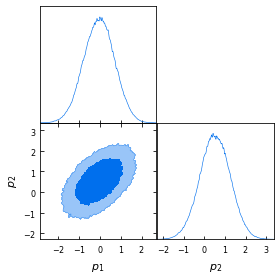

In [9]:
samples2 = MCSamples(samples=flat_samples_likelihood[:,:2],label='lik')

g = plots.get_subplot_plotter()
g.triangle_plot([samples2], filled=True)

In [10]:
np.cov(flat_samples_likelihood[:,0],flat_samples_likelihood[:,1])

array([[0.5374184 , 0.27641403],
       [0.27641403, 0.53641623]])

# Moment network

In [11]:
gc.collect()
validation_index = np.int(n_training * 0.8)
model_instance = demo.simple_leaky(size,2, learning_rate=1e-4)
regression = model_instance.model()

100
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)          

In [12]:
history = regression.fit(training_data[:validation_index],
                               training_z[:validation_index,:2],
                               epochs =7,batch_size =50, shuffle=True,
                               validation_data = (training_data[validation_index:],
                               training_z[validation_index:,:2]))

Epoch 1/7
1280/1280 [==============================] - 3s 2ms/step - loss: 0.6158 - val_loss: 0.5520
Epoch 2/7
1280/1280 [==============================] - 3s 2ms/step - loss: 0.5405 - val_loss: 0.5464
Epoch 3/7
1280/1280 [==============================] - 3s 2ms/step - loss: 0.5333 - val_loss: 0.5435
Epoch 4/7
1280/1280 [==============================] - 3s 2ms/step - loss: 0.5287 - val_loss: 0.5428
Epoch 5/7
1280/1280 [==============================] - 3s 2ms/step - loss: 0.5250 - val_loss: 0.5444
Epoch 6/7
1280/1280 [==============================] - 3s 2ms/step - loss: 0.5217 - val_loss: 0.5443
Epoch 7/7
1280/1280 [==============================] - 3s 2ms/step - loss: 0.5182 - val_loss: 0.5439


In [13]:
predicted_mean = regression.predict(np.atleast_2d(training_data))
predicted_mean_obs = regression.predict(np.atleast_2d(training_data_obs))

In [14]:
training_var_unknown_mean = (training_z[:,:2]-regression.predict(np.atleast_2d(training_data)))**2.
training_var_unknown_mean = np.hstack([training_var_unknown_mean,
                                      np.atleast_2d((training_z[:,0]-regression.predict(np.atleast_2d(training_data))[:,0])*
                                      (training_z[:,1]-regression.predict(np.atleast_2d(training_data))[:,1])).T])

In [16]:
model_instance = demo.simple_leaky(size,3, learning_rate=1e-4)
regression_var_unknown_mean = model_instance.model()
history = regression_var_unknown_mean.fit(training_data[:validation_index],
                               training_var_unknown_mean[:validation_index,:3],
                               epochs =5,batch_size =50, shuffle=True,
                               validation_data = (training_data[validation_index:],
                               training_var_unknown_mean[validation_index:,:3]))

100
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               20200     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100)          

In [17]:
likelihood_param_cov = np.cov(flat_samples_likelihood[:,0],flat_samples_likelihood[:,1])
predicted_var_obs = (regression_var_unknown_mean.predict(np.atleast_2d(training_data_obs[:]))[0])
print(predicted_var_obs)
moment_network_param_cov = np.copy(likelihood_param_cov)
moment_network_param_cov[0,0] = predicted_var_obs[0]
moment_network_param_cov[1,1] = predicted_var_obs[1]
moment_network_param_cov[0,1] = predicted_var_obs[2]
moment_network_param_cov[1,0] = predicted_var_obs[2]

[0.5245879  0.4871437  0.26472485]


In [18]:
moment_network_samples = np.array(np.random.multivariate_normal(predicted_mean_obs[0],moment_network_param_cov,int(1e6)),dtype=np.float32)
gc.collect()

4393

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

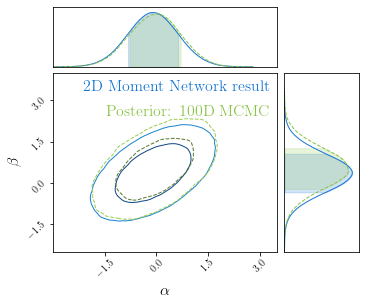

In [21]:
c = ChainConsumer()

c.add_chain(moment_network_samples,
            parameters=[r'$\alpha$', r'$\beta$'],
            name = '2D Moment Network result', color_params='C1')


c.add_chain(flat_samples_likelihood[:,:2],
            parameters=[r'$\alpha$', r'$\beta$'],
            name = 'Posterior: 100D MCMC', linestyle='--')

c.configure(kde=[1.,None],sigmas = [1,2],
            contour_label_font_size = 11,
            label_font_size = 16, shade = False) 

fig = c.plotter.plot(figsize = (5,4), extents=[[-3.,3.5],[-2.5,4]], filename='marginal_moments.pdf')
files.download('marginal_moments.pdf')